#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

#### Tratamento da Primeira Base - Organizando os Dados

In [2]:
df_passos_magicos = pd.read_csv(r'C:/Programas Python/Datathon/Base de dados - Passos Mágicos/PEDE_PASSOS_DATASET_FIAP.csv', sep = ';')

In [3]:
def tratativa_base_passos_magicos(df, year_list):
    combined_df = pd.DataFrame()

    for year in year_list:
        # Filtra as colunas que terminam com o ano especificado
        cols_with_year = [col for col in df.columns if col.endswith(f'_{year}')]
        
        # Cria novas colunas sem o ano
        new_columns = ['NOME', 'ANO'] + [col[:-5] for col in cols_with_year]
        
        # Cria um novo DataFrame temporário
        temp_df = pd.DataFrame(columns=new_columns)
        
        # Preenche o novo DataFrame com os dados correspondentes
        for index, row in df.iterrows():
            new_row = [row['NOME'], year] + [row[col] for col in cols_with_year]
            temp_df.loc[index] = new_row
        
        # Adiciona os dados processados ao DataFrame combinado
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    return combined_df

In [4]:
year_list = ['2020', '2021', '2022']
combined_df = tratativa_base_passos_magicos(df_passos_magicos, year_list)

Ajustando a coluna 'Fase_Turma' de 2020

In [5]:
combined_df.loc[combined_df['ANO'] == '2020', 'FASE'] = combined_df['FASE_TURMA'].str[0]
combined_df.loc[combined_df['ANO'] == '2020', 'TURMA'] = combined_df['FASE_TURMA'].str[1:]


C:\Users\Bruna\AppData\Local\Temp\ipykernel_20436\4268265788.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2' nan '3' ... '7' '3' nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.loc[combined_df['ANO'] == '2020', 'FASE'] = combined_df['FASE_TURMA'].str[0]


In [6]:
def cleaning_dataset(df):
    _df = df.dropna(subset=df.columns.difference(['NOME', 'ANO']), how='all') # executa o dropna para todas as colunas sem visualizar a coluna NOME
    _df = _df[~_df.isna().all(axis=1)] # remove linhas com apenas NaN, se tiver algum dado na linha não remove
    return _df

In [7]:
df_passos_magicos_cleaned = cleaning_dataset(combined_df)

Separando apenas as colunas que possui dados para os três anos

In [8]:
df_pm_not_nulls = df_passos_magicos_cleaned.dropna(axis=1, how='any')

In [9]:
df_pm_not_nulls = df_pm_not_nulls.copy()
df_pm_not_nulls.loc[:, 'PONTO_VIRADA'] = df_passos_magicos_cleaned['PONTO_VIRADA']
df_pm_not_nulls.loc[:, 'INDICADO_BOLSA'] = df_passos_magicos_cleaned['INDICADO_BOLSA']

Ajustando os dados numéricos

In [10]:
# Listar as colunas que você deseja arredondar
colunas_para_arredondar = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN']

# Arredondar as colunas selecionadas para 2 casas decimais
df_pm_not_nulls[colunas_para_arredondar] = df_pm_not_nulls[colunas_para_arredondar].apply(pd.to_numeric, errors='coerce')
df_pm_not_nulls[colunas_para_arredondar] = df_pm_not_nulls[colunas_para_arredondar].round(2)

Retirando dados sujos

In [11]:
# Filtrar os valores indesejados na coluna 'PEDRA'
valores_indesejados = ['#NULO!', 'D9891/2A']  # Liste aqui os valores que você quer excluir
df_pm_not_nulls = df_pm_not_nulls[~df_pm_not_nulls['PEDRA'].isin(valores_indesejados)]

In [12]:
df_pm_not_nulls

,NOME,ANO,INDE,PEDRA,IAA,IEG,IPS,IDA,IPP,IPV,IAN,FASE,TURMA,PONTO_VIRADA,INDICADO_BOLSA
0,ALUNO-1,2020,7.88,Ametista,8.50,8.70,7.50,7.00,5.94,7.75,10.0,2,H,Não,NaN
2,ALUNO-3,2020,7.86,Ametista,7.92,8.90,7.50,5.50,8.12,8.11,10.0,3,H,Não,NaN
3,ALUNO-4,2020,5.08,Quartzo,8.00,4.10,6.88,0.00,7.19,7.75,5.0,1,D,Não,NaN
4,ALUNO-5,2020,8.08,Ametista,7.50,8.00,7.50,7.50,8.44,8.17,10.0,2,M,Não,NaN
7,ALUNO-8,2020,8.38,Ametista,8.33,9.90,4.38,7.33,8.75,8.94,10.0,4,L,Sim,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4039,ALUNO-1342,2022,8.15,Topázio,7.92,9.67,7.50,7.75,6.25,7.50,10.0,2.0,K,Não,Não
4040,ALUNO-1343,2022,5.67,Quartzo,7.42,6.47,6.25,2.00,6.25,7.44,5.0,2.0,K,Não,Não
4043,ALUNO-1346,2022,8.14,Topázio,9.00,9.03,7.50,9.00,5.62,9.08,5.0,0.0,U,Sim,Não
4045,ALUNO-1348,2022,6.75,Ágata,8.33,9.18,5.62,5.90,6.72,5.83,5.0,4.0,P,Não,Não


#### Análises Iniciais

Distribuição de Alunos por valor de Pedras

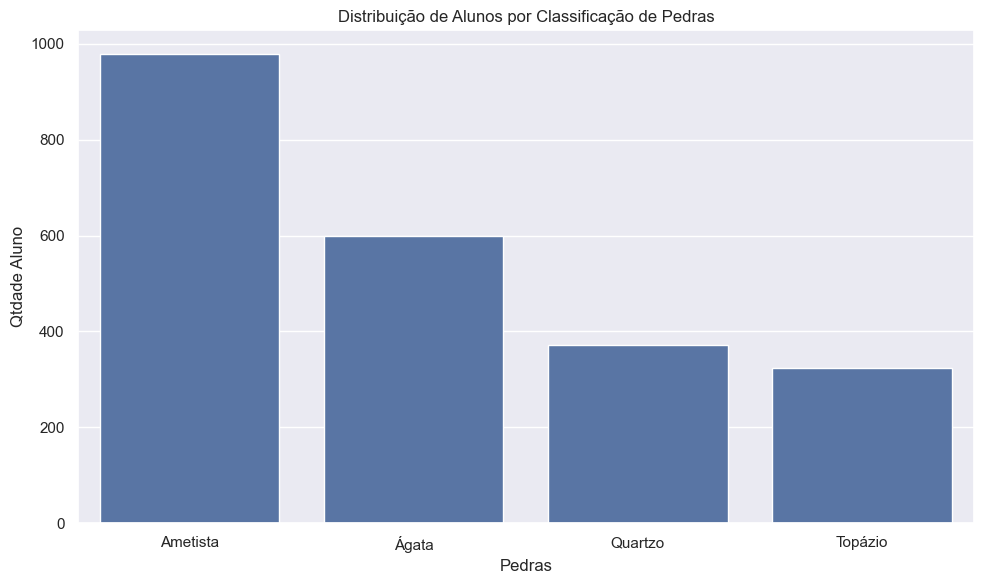

In [13]:
sns.set_theme(style="darkgrid")

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.countplot(data=df_pm_not_nulls, x='PEDRA', order=df_pm_not_nulls['PEDRA'].value_counts().index)
plt.title('Distribuição de Alunos por Classificação de Pedras')
plt.xlabel('Pedras')
plt.ylabel('Qtdade Aluno')
plt.tight_layout()
plt.show()

Criando um plot da variação de Pedras ao longo dos anos

In [14]:
df_grouped = df_pm_not_nulls.groupby(['ANO', 'PEDRA']).size().reset_index(name='Quantidade')

# Calcular a porcentagem dentro de cada grupo de 'ANO'
df_grouped['Porcentagem'] = df_grouped['Quantidade'] / df_grouped.groupby('ANO')['Quantidade'].transform('sum') * 100


In [15]:
df_grouped

,ANO,PEDRA,Quantidade,Porcentagem
0,2020,Ametista,336,46.217331
1,2020,Quartzo,128,17.606602
2,2020,Topázio,92,12.654746
3,2020,Ágata,171,23.521320
4,2021,Ametista,295,43.128655
5,2021,Quartzo,110,16.081871
6,2021,Topázio,101,14.766082
7,2021,Ágata,178,26.023392
8,2022,Ametista,348,40.371230
9,2022,Quartzo,134,15.545244


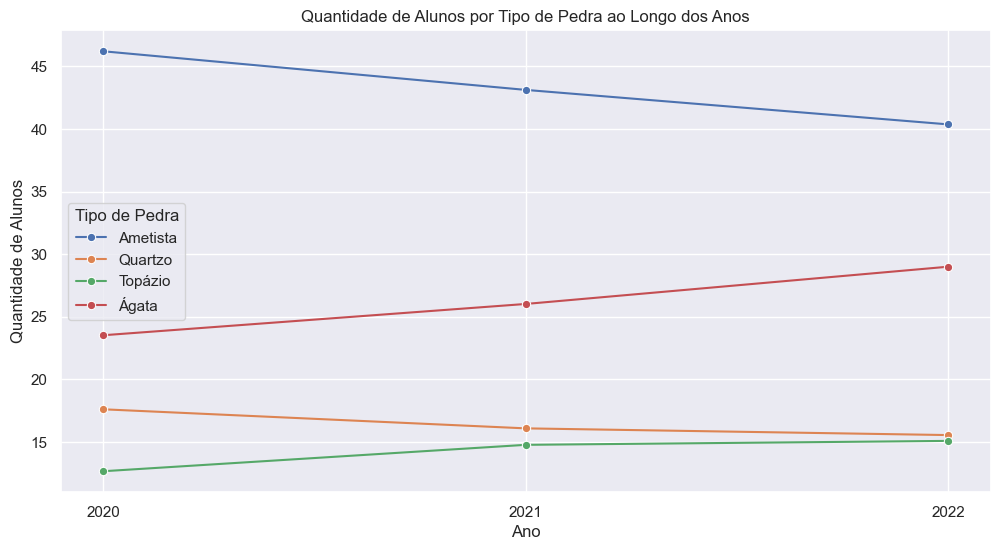

In [16]:
# Agora, podemos criar um gráfico de linha para mostrar a evolução da quantidade de alunos por pedra ao longo dos anos
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='ANO', y='Porcentagem', hue='PEDRA', marker='o')

plt.xlabel('Ano')
plt.ylabel('Quantidade de Alunos')
plt.title('Quantidade de Alunos por Tipo de Pedra ao Longo dos Anos')
plt.legend(title='Tipo de Pedra')
plt.show()

Ajustando a tabela onde a coluna 'PONTO_VIRADA' seja não nula e ajustando os seus valores para um valor numérico

In [17]:
df_ponto_virada = df_pm_not_nulls[df_pm_not_nulls['PONTO_VIRADA'].isnull() == False]

In [18]:
df_ponto_virada['PONTO_VIRADA_NUM'] = df_ponto_virada['PONTO_VIRADA'].map({'Sim': 1, 'Não': 0})


C:\Users\Bruna\AppData\Local\Temp\ipykernel_20436\2681331476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ponto_virada['PONTO_VIRADA_NUM'] = df_ponto_virada['PONTO_VIRADA'].map({'Sim': 1, 'Não': 0})


In [19]:
# Selecionar as colunas numéricas para a correlação, incluindo 'PONTO_VIRADA_NUM'
colunas_numericas = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'PONTO_VIRADA_NUM']
df_numerico = df_ponto_virada[colunas_numericas]

# Calcular a matriz de correlação
matriz_correlacao = df_numerico.corr()

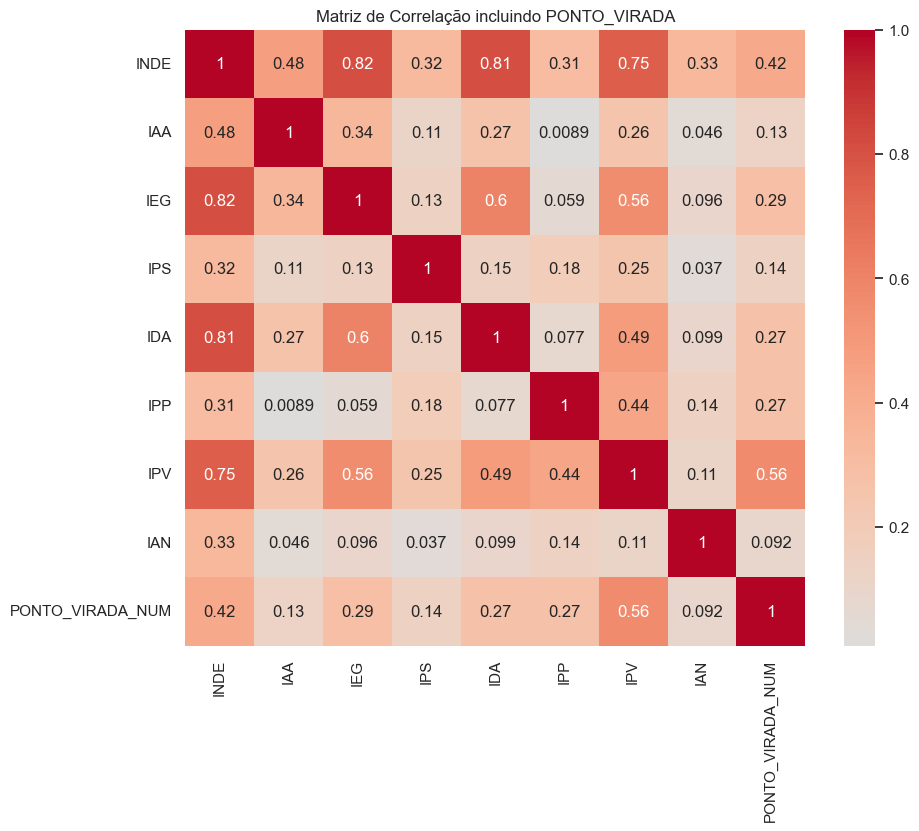

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação incluindo PONTO_VIRADA')
plt.show()

#### Criando o modelo para Ponto de Virada

Vamos usar todos os índices para construir um modelo de previsão do ponto de virada

In [21]:
#Separando as variáveis
x = df_ponto_virada[['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN']]
y = df_ponto_virada["PONTO_VIRADA_NUM"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

Usando o KNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=9)

In [24]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [25]:
accuracy = knn.score(x_test, y_test)
print(accuracy)

0.9422222222222222


In [26]:
scaler.fit(x_train)

x_train_escalonado = scaler.transform(x_train)
x_test_escalonado = scaler.transform(x_test)

In [27]:
error = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_escalonado, y_train)
    pred_i = knn.predict(x_test_escalonado)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Valor de K')

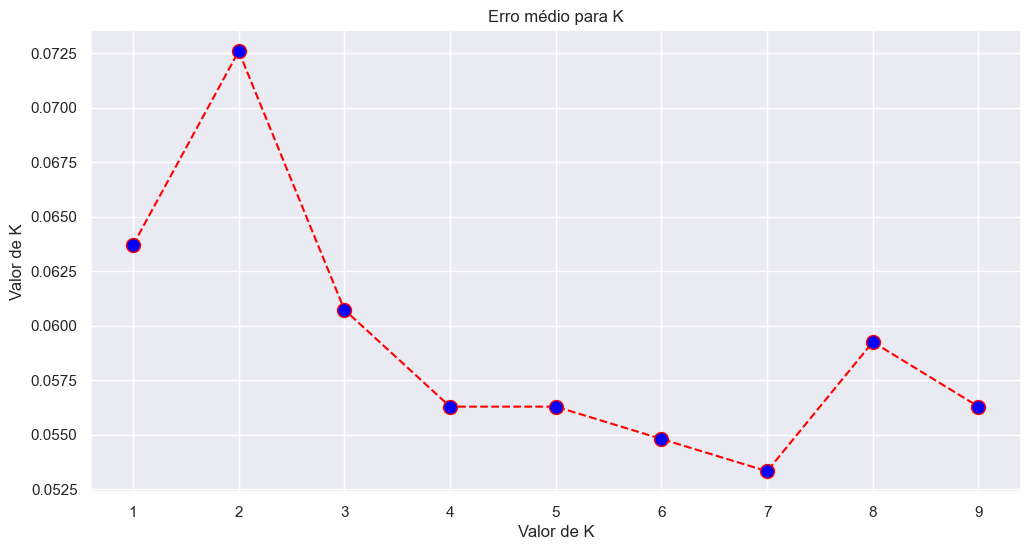

In [28]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10), error, color="red", linestyle = "dashed", marker = "o", markerfacecolor = "blue", markersize = 10)

plt.title("Erro médio para K")
plt.xlabel("Valor de K")
plt.ylabel("Valor de K")

Usando o K=7

In [29]:
knn = KNeighborsClassifier(n_neighbors=7)

In [30]:
knn.fit(x_train, y_train)
accuracy = knn.score(x_test, y_test)
print(accuracy)

0.9422222222222222


Como a acurácia deu um valor alto, vamos fazer uma validação cruzada com 5 grupos diferentes dos mesmos dados para verificar se há um overfitting ou a performance está boa para diferentes grupos de dados. Faremos isso para todos os modelos que tiverem um valor alto de acurácia

In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, x, y, cv=5)
print("Acurácias na Validação Cruzada:", scores)
print("Média da Acurácia:", scores.mean())
print("Desvio Padrão das Acurácias:", scores.std())


Acurácias na Validação Cruzada: [0.91777778 0.94222222 0.95545657 0.91982183 0.922049  ]
Média da Acurácia: 0.9314654788418707
Desvio Padrão das Acurácias: 0.014851787176630021


Usando o Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=40)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_pred)
print(accuracy_rf)

0.9733333333333334


In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, x, y, cv=5)
print("Acurácias na Validação Cruzada:", scores)
print("Média da Acurácia:", scores.mean())
print("Desvio Padrão das Acurácias:", scores.std())

Acurácias na Validação Cruzada: [0.95777778 0.98       0.91091314 0.95100223 0.94877506]
Média da Acurácia: 0.9496936401880722
Desvio Padrão das Acurácias: 0.022317312085757605


Usando o SVM

In [34]:
from sklearn.svm import SVC
svm_model_pv = SVC(kernel='linear', random_state=40) 

svm_model_pv.fit(x_train, y_train)
y_pred_svm = svm_model_pv.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.96


In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model_pv, x, y, cv=5)
print("Acurácias na Validação Cruzada:", scores)
print("Média da Acurácia:", scores.mean())
print("Desvio Padrão das Acurácias:", scores.std())

Acurácias na Validação Cruzada: [0.97555556 0.96888889 0.91536748 0.95100223 0.93986637]
Média da Acurácia: 0.9501361049245236
Desvio Padrão das Acurácias: 0.021507626813963992


Com base nos indicadores, percebemos que os modelos estão bem performático e não há overfiting. Vamos escolher o modelo SVC por ter a maior média de acurácia e um desvio padrão não tão maior que os demais.

#### Criando o modelo para Indicação da Bolsa

Separando o dataframe para análise de previsão de indicação da bolsa

In [36]:
df_indicado_bolsa = df_pm_not_nulls[df_pm_not_nulls['INDICADO_BOLSA'].isnull() == False]

In [37]:
# Converter 'INDICADO_BOLSA' de "Sim"/"Não" para 1/0
df_indicado_bolsa['INDICADO_BOLSA_NUM'] = df_indicado_bolsa['INDICADO_BOLSA'].map({'Sim': 1, 'Não': 0})

C:\Users\Bruna\AppData\Local\Temp\ipykernel_20436\87892717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indicado_bolsa['INDICADO_BOLSA_NUM'] = df_indicado_bolsa['INDICADO_BOLSA'].map({'Sim': 1, 'Não': 0})


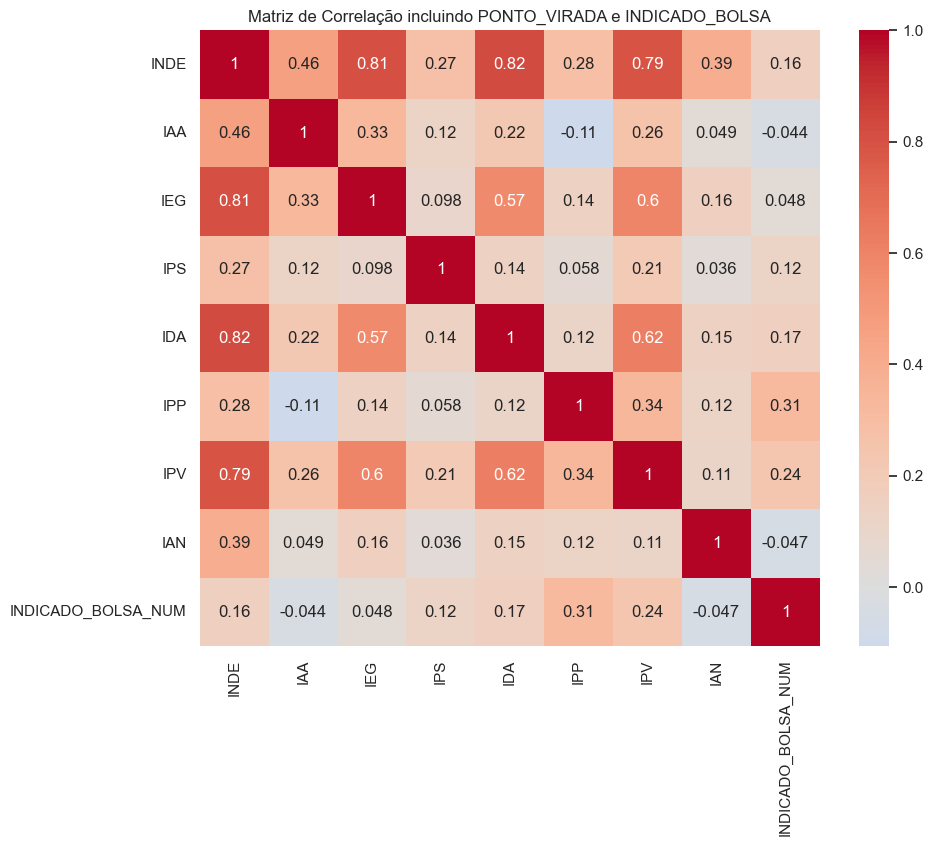

In [38]:
# Selecionar as colunas numéricas para a correlação, incluindo 'PONTO_VIRADA_NUM' e 'INDICADO_BOLSA_NUM'
colunas_numericas = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'INDICADO_BOLSA_NUM']
df_numerico = df_indicado_bolsa[colunas_numericas]

# Calcular a matriz de correlação
matriz_correlacao = df_numerico.corr()

# Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação incluindo PONTO_VIRADA e INDICADO_BOLSA')
plt.show()

Com base nos valores encontrados na matriz de correlação, vamos seguir com as features IPP e IPV para prever a INDICAÇÃO DE BOLSA

In [39]:
df_indicado_bolsa.describe()

,INDE,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDICADO_BOLSA_NUM
count,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000
mean,7.028341,8.263248,7.880882,6.900766,6.070812,6.298480,7.247981,6.421114,0.153132
std,1.029892,2.080193,1.649087,1.070532,2.059343,1.135919,1.098771,2.387816,0.360324
min,3.030000,0.000000,0.000000,2.500000,0.000000,0.000000,2.500000,2.500000,0.000000
25%,6.472500,7.920000,7.000000,6.250000,4.750000,5.620000,6.720000,5.000000,0.000000
50%,7.195000,8.750000,8.310000,7.500000,6.330000,6.250000,7.330000,5.000000,0.000000
75%,7.750000,9.500000,9.100000,7.500000,7.580000,7.030000,7.920000,10.000000,0.000000
max,9.440000,10.000000,10.000000,10.000000,9.920000,9.220000,10.000000,10.000000,1.000000


In [40]:
#Separando as variáveis
x = df_indicado_bolsa[["IPV", "IPP"]]
y = df_indicado_bolsa["INDICADO_BOLSA_NUM"]

Usando Kneigbhor

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [43]:
knn.fit(x_train, y_train)  #Armazena os dados de treinamento para uso

KNeighborsClassifier(n_neighbors=12)

In [44]:
accuracy = knn.score(x_test, y_test)

In [45]:
accuracy

0.8148148148148148

Utilizando o erro médio para escolher o melhor K para o modelo

In [46]:
scaler.fit(x_train)

x_train_escalonado = scaler.transform(x_train)
x_test_escalonado = scaler.transform(x_test)

In [47]:
error = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_escalonado, y_train)
    pred_i = knn.predict(x_test_escalonado)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Valor de K')

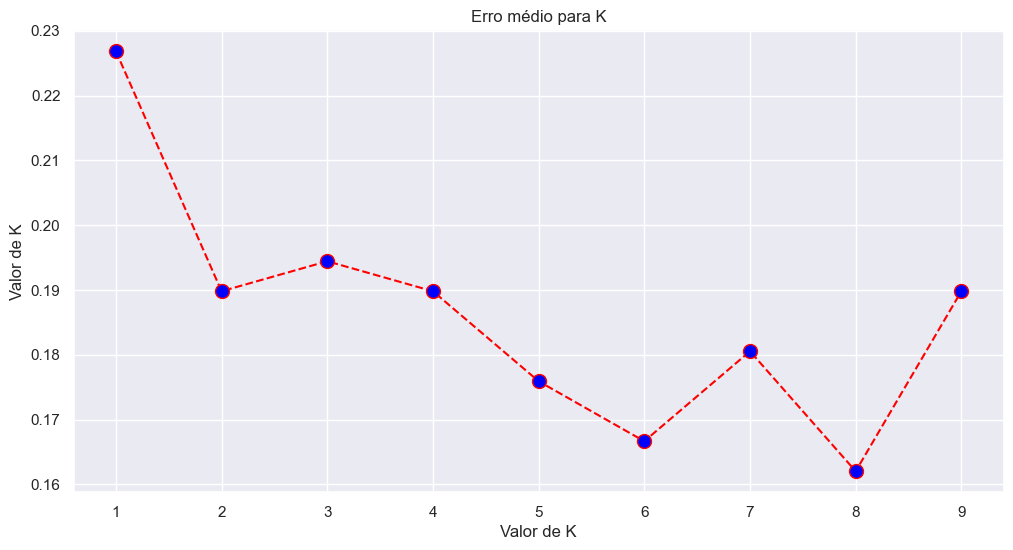

In [48]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10), error, color="red", linestyle = "dashed", marker = "o", markerfacecolor = "blue", markersize = 10)

plt.title("Erro médio para K")
plt.xlabel("Valor de K")
plt.ylabel("Valor de K")

Com base no gráfico, podemos ver que 5, 6 e 9 são os valores com menor erro. Vamos seguir com o K=6 para que o modelo não fique tão sensível à ruídos

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn_b = KNeighborsClassifier(n_neighbors=8)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
knn_b.fit(x_train, y_train)
accuracy = knn_b.score(x_test, y_test)
print(accuracy)

0.8379629629629629


Usando Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [51]:
accuracy_rf = accuracy_score(y_test, y_pred)
print(accuracy_rf)

0.8009259259259259


Usando Support Vector Machine (SVM) Classifier

In [52]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42) 

svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.8240740740740741


De acordo com a acurácia, vamos manter o modelo SVM para o modelo de INDICAÇÃO DA BOLSA

#### Salvando os modelos

In [53]:
# Salvando o modelo
dump(svm_model_pv, 'modelo_svm_pv.joblib')

['modelo_svm_pv.joblib']

In [55]:
# Salvando o modelo
dump(knn_b, 'modelo_knn.joblib')

['modelo_knn.joblib']